In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, inference_time

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_shape = (batch_size, 3, 32, 32)
num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from Models import VGGNet

VGGNN = VGGNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device, p_drop=0.2)

summary(VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-7                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-9                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-10                        [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-11                   [100, 64, 8, 8]           --
│  

In [11]:
PATH = "models/VGG/VGGNet.pth"

if exists(PATH):
    VGGNN = torch.load(PATH)
    VGGNN.eval()

In [14]:
criterion = CrossEntropyLoss()
%timeit test_loss(VGGNN.to("cpu"), test_dataloader, criterion, device="cpu")

5.24 s ± 309 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
from util import inference_time


print(inference_time(VGGNN, test_dataloader, device)[1]*1e-9)

1.4369093050000001


In [12]:
criterion = CrossEntropyLoss()

train_NN(VGGNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 2.304
test_loss: 2.304, test_accuracy: 10.0
[1,   200] train_loss: 2.304
test_loss: 2.304, test_accuracy: 10.0
[1,   300] train_loss: 2.297
test_loss: 2.230, test_accuracy: 17.77
[1,   400] train_loss: 2.131
test_loss: 2.061, test_accuracy: 22.9
[1,   500] train_loss: 2.043
test_loss: 1.919, test_accuracy: 28.31
[2,   100] train_loss: 1.914
test_loss: 1.810, test_accuracy: 30.45
[2,   200] train_loss: 1.835
test_loss: 1.754, test_accuracy: 32.58
[2,   300] train_loss: 1.801
test_loss: 1.740, test_accuracy: 32.86
[2,   400] train_loss: 1.790
test_loss: 1.644, test_accuracy: 36.57
[2,   500] train_loss: 1.749
test_loss: 1.617, test_accuracy: 39.17
[3,   100] train_loss: 1.724
test_loss: 1.615, test_accuracy: 37.36
[3,   200] train_loss: 1.722
test_loss: 1.626, test_accuracy: 38.03
[3,   300] train_loss: 1.716
test_loss: 1.653, test_accuracy: 38.31
[3,   400] train_loss: 1.706
test_loss: 1.603, test_accuracy: 39.99
[3,   500] train_loss: 1.721
test_loss: 1.587, test

In [15]:
torch.save(VGGNN, "./models/VGG/VGGNet.pth")

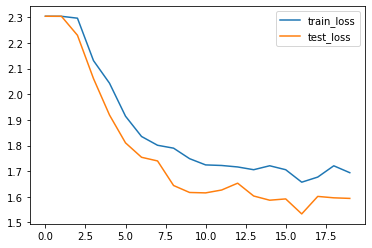

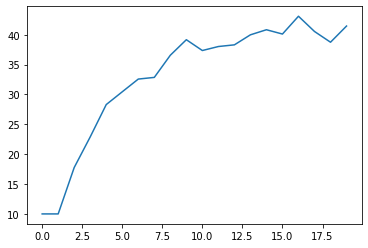

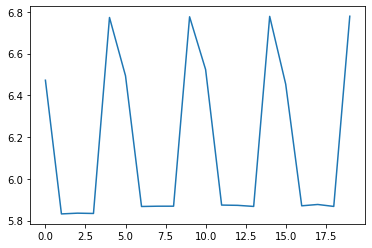

In [16]:
plt.plot(VGGNN.train_loss, label="train_loss")
plt.plot(VGGNN.test_loss, label = "test_loss")
plt.legend()
plt.show()
plt.plot(VGGNN.test_accuracy)
plt.show()
plt.plot(VGGNN.train_time)
plt.show()

In [4]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device, p_drop=0.2, expansion_rate=2)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        4,448
│    │    └─Identity: 3-2                [100, 32, 32, 32]         --
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-3              --                        4,448
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         2,112
│    

In [9]:
PATH = "models/VGG/ASL_VGGNet.pth"

if exists(PATH):
    ASL_VGGNN = torch.load(PATH)
    ASL_VGGNN.eval()

In [17]:
print(inference_time(ASL_VGGNN,test_dataloader, device)[1]*1e-9)

3.589170832


In [5]:
criterion = CrossEntropyLoss()

train_NN(ASL_VGGNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 2.088
test_loss: 1.825, test_accuracy: 32.86
[1,   200] train_loss: 1.832
test_loss: 1.718, test_accuracy: 35.31
[1,   300] train_loss: 1.762
test_loss: 1.629, test_accuracy: 39.43
[1,   400] train_loss: 1.741
test_loss: 1.629, test_accuracy: 37.89
[1,   500] train_loss: 1.764
test_loss: 1.636, test_accuracy: 39.55
[2,   100] train_loss: 1.730
test_loss: 1.572, test_accuracy: 40.65
[2,   200] train_loss: 1.723
test_loss: 1.581, test_accuracy: 40.64
[2,   300] train_loss: 1.718
test_loss: 1.565, test_accuracy: 42.13
[2,   400] train_loss: 1.729
test_loss: 1.583, test_accuracy: 40.93
[2,   500] train_loss: 1.709
test_loss: 1.552, test_accuracy: 43.83
[3,   100] train_loss: 1.667
test_loss: 1.505, test_accuracy: 45.09
[3,   200] train_loss: 1.638
test_loss: 1.506, test_accuracy: 44.29
[3,   300] train_loss: 1.654
test_loss: 1.505, test_accuracy: 44.38
[3,   400] train_loss: 1.643
test_loss: 1.500, test_accuracy: 44.88
[3,   500] train_loss: 1.618
test_loss: 1.483, t

In [7]:
torch.save(ASL_VGGNN, "./models/VGG/ASL_VGGNet.pth")

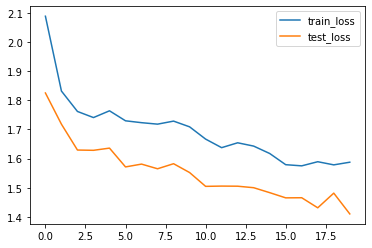

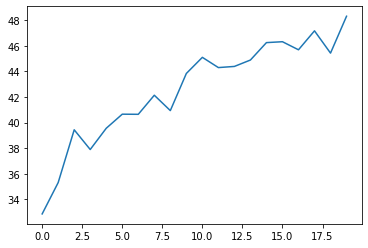

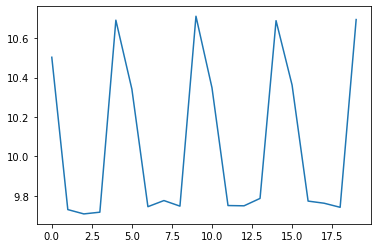

In [6]:
plt.plot(ASL_VGGNN.train_loss, label="train_loss")
plt.plot(ASL_VGGNN.test_loss, label = "test_loss")
plt.legend()
plt.show()
plt.plot(ASL_VGGNN.test_accuracy)
plt.show()
plt.plot(ASL_VGGNN.train_time)
plt.show()

CSC-block 1


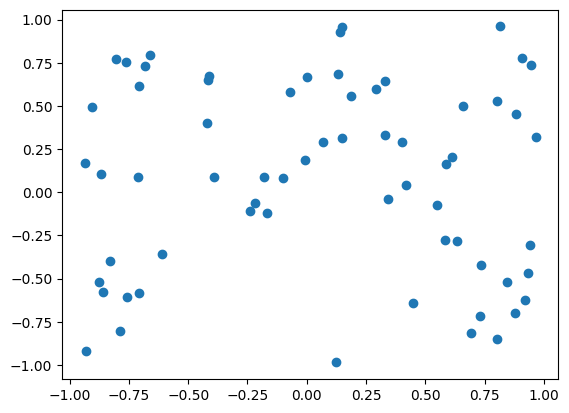

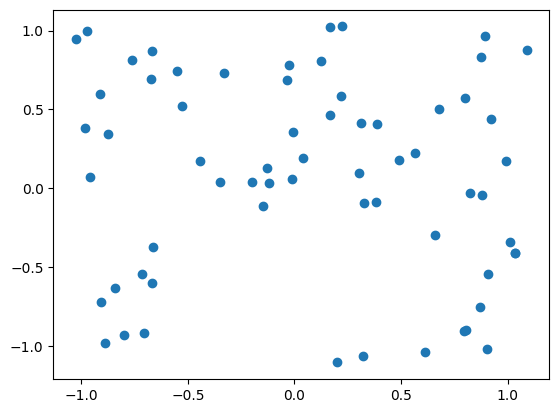

CSC-block 2


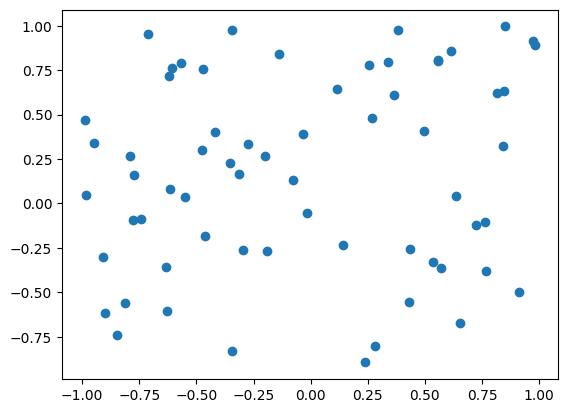

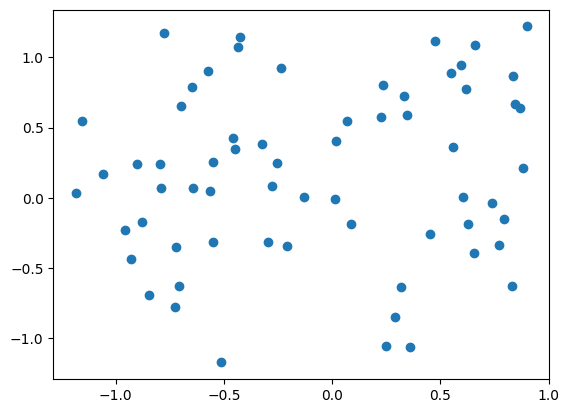

CSC-block 3


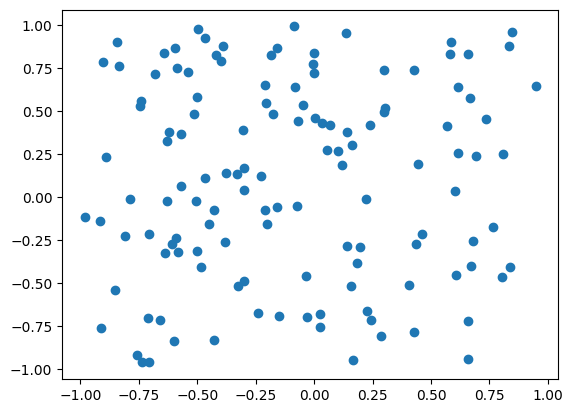

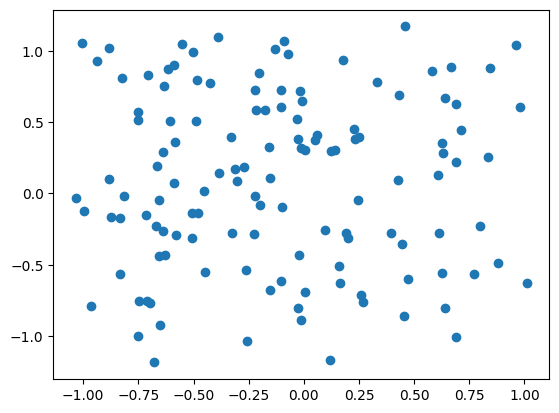

CSC-block 4


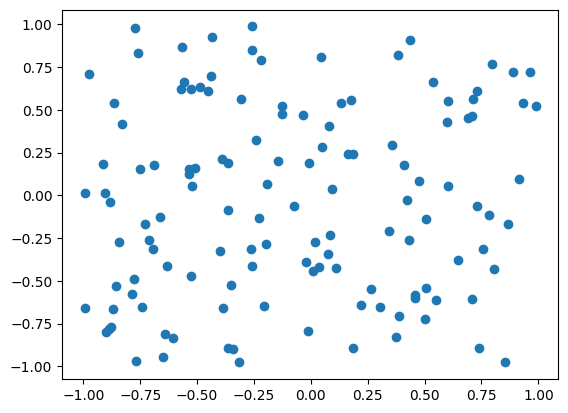

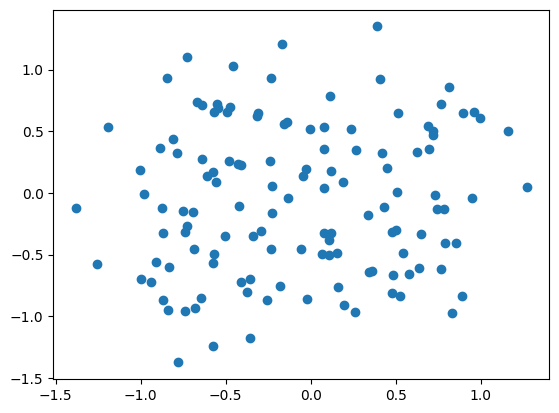

CSC-block 5


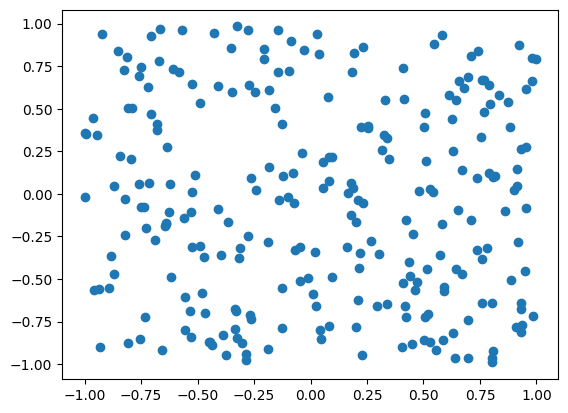

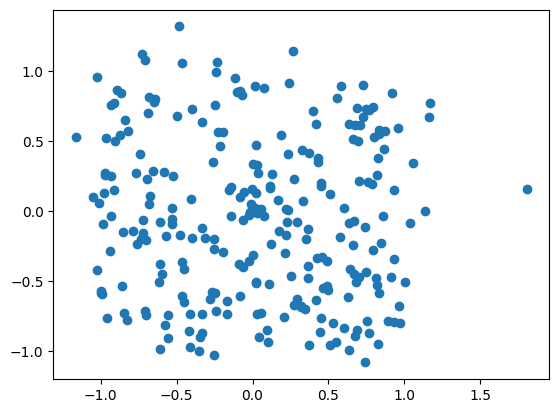

In [10]:
print("CSC-block 1")
CSC_block = ASL_VGGNN.NN[2]
points = CSC_block.NN[3].shifts.detach().to("cpu").numpy()
initial_points = CSC_block.NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

print("CSC-block 2")
CSC_block = ASL_VGGNN.NN[6]
points = CSC_block.NN[3].shifts.detach().to("cpu").numpy()
initial_points = CSC_block.NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

print("CSC-block 3")
CSC_block = ASL_VGGNN.NN[8]
points = CSC_block.NN[3].shifts.detach().to("cpu").numpy()
initial_points = CSC_block.NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

print("CSC-block 4")
CSC_block = ASL_VGGNN.NN[12]
points = CSC_block.NN[3].shifts.detach().to("cpu").numpy()
initial_points = CSC_block.NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

print("CSC-block 5")
CSC_block = ASL_VGGNN.NN[14]
points = CSC_block.NN[3].shifts.detach().to("cpu").numpy()
initial_points = CSC_block.NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [4]:
from ActiveShiftLayer import CSC_block
from torch.nn import Conv2d

device = 'cuda'

testLayer = CSC_block(3, 3, 1, device)
ts_perf = []
ts_proc = []

for i in range(100):
    time = inference_time(testLayer, test_dataloader, device)
    ts_perf.append(time[1]*1e-9)
    ts_proc.append(time[0]*1e-9)
ts = np.array(ts_perf)
print(ts.mean(), ts.std())
ts = np.array(ts_proc)
print(ts.mean(), ts.std())




0.12635121128000001 0.06478476620157715
0.12589700520000002 0.06399246923323704


<ErrorbarContainer object of 3 artists>

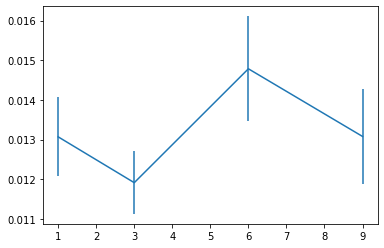

In [9]:
t_kernel = []
std_kernel = []
for kernelsize in [1,3,6,9]:
    testLayer2 = Conv2d(3,3,kernelsize, device=device, padding='same')
    ts_perf = []
    ts_proc = []

    for i in range(50):
        time = inference_time(testLayer2, test_dataloader, device)
        ts_perf.append(time[1]*1e-9)
        ts_proc.append(time[0]*1e-9)
    ts = np.array(ts_perf)
    t_kernel.append(ts.mean())
    std_kernel.append(ts.std())
plt.errorbar(np.array([1,3,6,9]),t_kernel, std_kernel)

In [5]:
from ActiveShiftLayer import ASL

testLayer2 = ASL(3, device)
ts_perf = []
ts_proc = []

for i in range(100):
    time = inference_time(testLayer2, test_dataloader, device)
    ts_perf.append(time[1]*1e-9)
    ts_proc.append(time[0]*1e-9)
ts = np.array(ts_perf)
print(ts.mean(), ts.std())
ts = np.array(ts_proc)
print(ts.mean(), ts.std())

0.08700848331 0.008634361212360955
0.08662699218 0.008570521354232793
